In [1]:
# Core jax
import jax
# from jax.config import config
jax.config.update("jax_enable_x64", True)

import jax.numpy as np
import jax.random as jr

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.utils as dlu

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from dLuxToliman import ApplyBasisCLIMB, TolimanOpticalSystem

# gonna have to define my own log likelihoods which are analytic contiuations???

from jax.scipy.special import gammaln, xlogy

def poisson_loglike_gamma(k, mu):
    # analytic continuation using gammaln(k+1)
    k = np.asarray(k)
    mu = np.asarray(mu)
    valid = (k >= 0) & np.isfinite(k) & (mu > 0) & np.isfinite(mu)
    logp = xlogy(k, mu) - mu - gammaln(k + 1.0)
    return np.where(valid, logp, -np.inf)

def poisson_loglike_unnormalized(k, mu):
    # returns k*log(mu) - mu  (no normalization constant)
    return xlogy(k, mu) - mu

# define the likelihood function:
def poiss_loglike(pytree, data) -> float:
    """
    Poissonian log likelihood of the pytree given the data. Assumes the pytree
    has a .model() function.

    Parameters
    ----------
    pytree : Base
        Pytree with a .model() function.
    data : Array
        Data to compare the model to.

    Returns
    -------
    log_likelihood : Array
        Log likelihood of the pytree given the data.
    """
    return poisson_loglike_gamma(pytree.model(), data).sum()

plt.rcParams["image.origin"] = 'lower'

from pathlib import Path

In [2]:
# Marginal params
marginal_params = 'position'

# Loss function
opt_param = 'pupil.coefficients'
@zdx.filter_jit
@zdx.filter_value_and_grad(opt_param)

def fim_loss_func(optics, sources, detector, parameters):
    covs = []
    for source in sources:
        model = dl.Telescope(optics, source, detector)
        data = model.model()
        cov = zdx.covariance_matrix(model, parameters, poiss_loglike, data=data)
        covs.append(cov)

    # convert list -> array: shape (n_sources, n_params, n_params)
    covs_arr = np.stack(covs)   # or np.asarray(covs)

    # trace over the last two axes to get one trace per source
    traces = np.trace(covs_arr, axis1=-2, axis2=-1)   # shape (n_sources,)

    # take maximum trace across sources
    max_trace = np.max(traces)

    # log it
    loss = np.log(max_trace)

    return loss

In [3]:
n_sources = 20
key = jr.PRNGKey(0)

positions = jr.uniform(key, (n_sources,2))

print(positions)
wf_npix = 256 
diameter = 0.125 # This is default of toliman optical system. Can change.

### Can apply these to the input if you just want a clear aperture
m2_diameter = 0
strut_width = 0
###

wavelength = 585e-9

# This is to what degree we undersample Nyquist
nyquist_factor = 16
psf_npix = 256 / nyquist_factor
psf_pixel_scale = nyquist_factor * dlu.rad2arcsec(wavelength/(2*diameter))
oversample = nyquist_factor * 4 # sample at 4x nyquist originally

# Place the source in the centre of the top right from center pixel.
# That's what the position argument does here
sources = []
for i in np.arange(n_sources):
    position = positions[i]
    source = dl.PointSource(flux=1e6,position=dlu.arcsec2rad(psf_pixel_scale*position),wavelengths=np.array([wavelength]))
    sources.append(source)

# Optimisable binary mask
climb_basis = np.load("../xk4/files/basis.npy")
coefficients = 100*jr.normal(key, [len(climb_basis)])
mean_wl = source.wavelengths.mean()

# have to make sure that mean_wl is in meters.
mask_layer = ApplyBasisCLIMB(climb_basis, mean_wl, coefficients)

# Construct instrument
optics = TolimanOpticalSystem(wf_npixels=wf_npix,psf_npixels=psf_npix, mask=mask_layer, 
                            radial_orders=[2, 3], psf_pixel_scale=psf_pixel_scale, oversample=oversample)

# detector layer
detector_layers = [
    (
        'downsample',
        dl.detector_layers.Downsample(oversample)
    )
]

detector = dl.LayeredDetector(layers = detector_layers)

[[0.30302224 0.72645676]
 [0.06488892 0.76531855]
 [0.22793581 0.74866272]
 [0.74522618 0.79668145]
 [0.50800239 0.23064615]
 [0.48315882 0.97375015]
 [0.81619893 0.17797163]
 [0.65629133 0.17255094]
 [0.58606728 0.55044548]
 [0.50006767 0.14053897]
 [0.91536863 0.95206751]
 [0.6955056  0.35066579]
 [0.57493719 0.98435491]
 [0.43722285 0.64461826]
 [0.72090951 0.43140401]
 [0.94462764 0.57443854]
 [0.01658851 0.74624837]
 [0.74148144 0.77479652]
 [0.78635059 0.31579775]
 [0.01176115 0.22395309]]


In [4]:
#fim_loss_func(optics, sources, detector, marginal_params)

optim, opt_state = zdx.get_optimiser(optics, opt_param, optax.adam(2e1))

losses, models_out = [], [optics]
with tqdm(range(100), desc='Gradient Descent') as t:
    for i in t:
        loss, grads = fim_loss_func(optics, sources, detector, marginal_params)
        updates, opt_state = optim.update(grads, opt_state)   # your zdx API
        optics = zdx.apply_updates(optics, updates)
        models_out.append(optics)
        losses.append(loss)
        t.set_description("Loss: {:.6f}".format(float(loss)))


Gradient Descent:   0%|          | 0/100 [00:00<?, ?it/s]

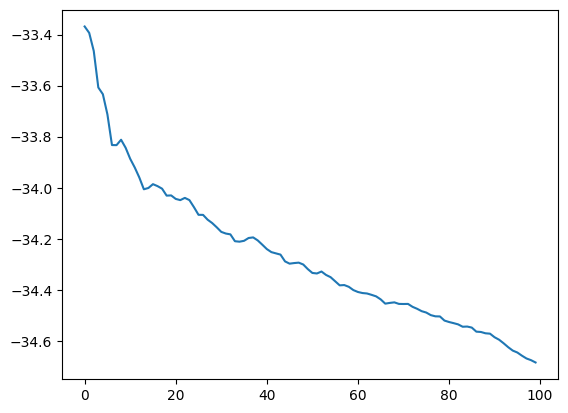

In [5]:
plt.plot(losses)

In [21]:
trace_covs = []
for source in sources:
    traces = []
    for optics in models_out[::20]:

        model = dl.Telescope(optics, source, detector)

        data = model.model()
        cov = zdx.covariance_matrix(model, marginal_params, poiss_loglike, data=data)
        trace = np.trace(cov)
        traces.append(trace)
        print('hi')

    trace_covs.append(traces)


hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi


In [106]:
# Airy:
coords = dlu.pixel_coords(wf_npix, diameter)
airy_aperture = dlu.circle(coords, 0.5*diameter)
airy_layers = [
    (
        'aperture',
        dl.TransmissiveLayer(airy_aperture,normalise=True)
    )
]
optics_airy = dl.AngularOpticalSystem(wf_npixels = wf_npix, diameter = diameter, layers=airy_layers,
                                      psf_npixels=psf_npix,psf_pixel_scale=psf_pixel_scale,oversample=oversample)

# Zernike defocus
import dLuxToliman as dlT
defocus_layers = [
    (
        'aperture',
        dlT.TolimanApertureLayer(wf_npix)
    ),
    (
        'defocus',
        dl.AberratedLayer(opd = 0.45*0.75*wavelength*dlu.zernike(4,coords,diameter))
    )
]
optics_defocus = dl.AngularOpticalSystem(wf_npixels = wf_npix, diameter = diameter, layers=defocus_layers,
                                      psf_npixels=psf_npix,psf_pixel_scale=psf_pixel_scale,oversample=oversample)


traces_airy = []
traces_defocus = []
for source in sources:

    model_airy = dl.Telescope(optics_airy,source,detector)

    data_airy = model_airy.model()
    covs_airy = zdx.covariance_matrix(model_airy, marginal_params, poiss_loglike, data=data_airy)
    trace_airy = np.trace(covs_airy)
    traces_airy.append(trace_airy)

    model_defocus = dl.Telescope(optics_defocus, source, detector)
    data_defocus = model_defocus.model()
    covs_defocus = zdx.covariance_matrix(model_defocus, marginal_params, poiss_loglike, data=data_defocus)
    trace_defocus = np.trace(covs_defocus)
    traces_defocus.append(trace_defocus)

traces_airy = np.asarray(traces_airy)
traces_defocus = np.asarray(traces_defocus)

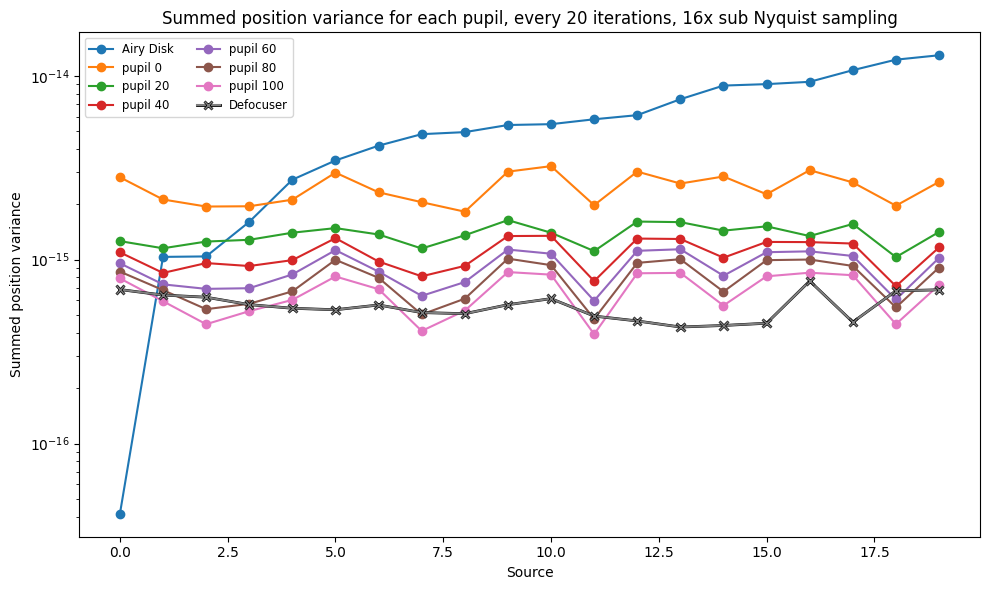

In [ ]:
import matplotlib.patheffects as pe
path_effects = [pe.Stroke(linewidth=2, foreground='k'), pe.Normal()]

arr= np.asarray([np.asarray(t) for t in trace_covs])

arr = arr.T
n_optics, n_sources = arr.shape

# compute permutation that sorts sources by increasing traces_airy
order = np.argsort(traces_airy)    # indices of sources in increasing Airy-trace order

# reorder Airy and arr columns

traces_airy_sorted = traces_airy[order]
arr_sorted = arr[:, order]           # now shape still (n_optics, n_sources)
defocus_sorted = traces_defocus[order]

plt.figure(figsize=(10, 6))
plt.plot(traces_airy_sorted, label='Airy Disk', marker='o')

for i in range(n_optics):
    plt.plot(arr_sorted[i], marker='o', label=f'pupil {20*i}')   # change label if you want index meaning

plt.plot(defocus_sorted, label='Defocuser', marker='x', path_effects=path_effects)

plt.xlabel("Source")
plt.ylabel("Summed position variance")
plt.title("Summed position variance for each pupil, every 20 iterations, 16x sub Nyquist sampling")
plt.yscale('log')
#plt.xticks(x, labels, rotation=45, ha='right')
plt.legend(ncol=2, fontsize='small')
#plt.grid(True)
plt.tight_layout()
plt.show()

# gotta optimise a bit better than that if we want to beat the defocuser!

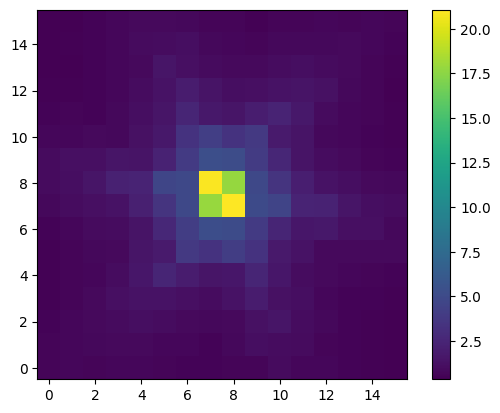

In [86]:
plt.imshow(dlu.downsample(models_out[-1].propagate(np.array([585e-9]))**0.5, 64, False))
# plt.xlim(512-256,512+256)
# plt.ylim(512-256,512+256)
plt.colorbar()
plt.show()

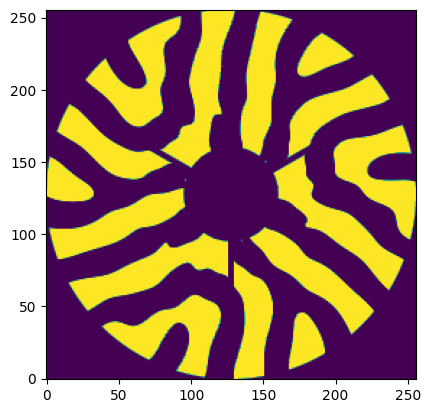

In [88]:
plt.imshow(models_out[-1].pupil.get_binary_phase()*models_out[-1].aperture.transmission)
plt.show()

In [89]:
np.save('20_source_16x_subsample.npy', models_out[-1].pupil.get_binary_phase())

In [55]:
# Airy:
coords = dlu.pixel_coords(wf_npix, diameter)
airy_aperture = dlu.circle(coords, 0.5*diameter)
airy_layers = [
    (
        'aperture',
        dl.TransmissiveLayer(airy_aperture,normalise=True)
    )
]
optics_airy = dl.AngularOpticalSystem(wf_npixels = wf_npix, diameter = diameter, layers=airy_layers,
                                      psf_npixels=psf_npix,psf_pixel_scale=psf_pixel_scale,oversample=oversample)
model_airy = dl.Telescope(optics_airy,sources[3],detector)

data_airy = model_airy.model()
covs_airy = zdx.covariance_matrix(model_airy, marginal_params, poiss_loglike, data=data_airy)

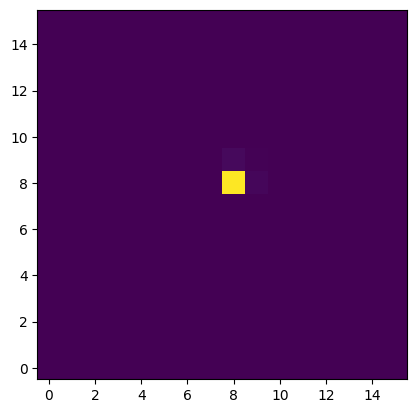

In [17]:
plt.imshow(data_airy)

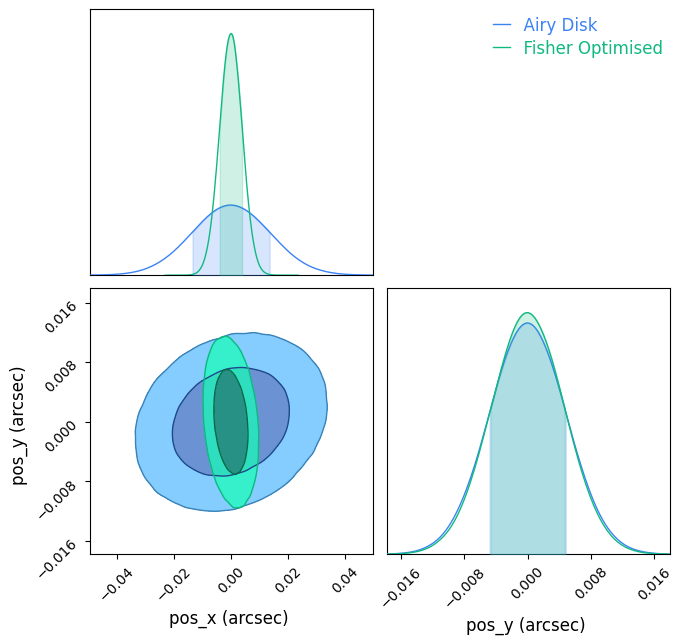

In [18]:
from chainconsumer import ChainConsumer, Chain
param_names = ["pos_x (arcsec)", "pos_y (arcsec)"]
X = np.zeros(len(param_names))

c = ChainConsumer()
# This 'commented out' one is just before optimisation
# c.add_chain(
#     Chain.from_covariance(mean=X, covariance=dlu.rad2arcsec(covs[0]), columns=param_names, name="Initial")
# )

# To convert to arcsec, have to square the conversion factor
cov_to_arcsec = dlu.rad2arcsec(1)**2
c.add_chain(
    Chain.from_covariance(mean=X, covariance=covs_airy*cov_to_arcsec, columns=param_names, name="Airy Disk")
)
# c.add_chain(
#     Chain.from_covariance(mean=X, covariance=covs_defocus*cov_to_arcsec, columns=param_names, name='Defocuser')
# )
# c.add_chain(
#     Chain.from_covariance(mean=X, covariance=covs_tol*cov_to_arcsec, columns=param_names, name="Toliman Aperture")
# )
c.add_chain(
    Chain.from_covariance(mean=X, covariance=cov_best*cov_to_arcsec, columns=param_names, name="Fisher Optimised")
)

#c.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)
fig = c.plotter.plot()
# Very cool/interesting results!

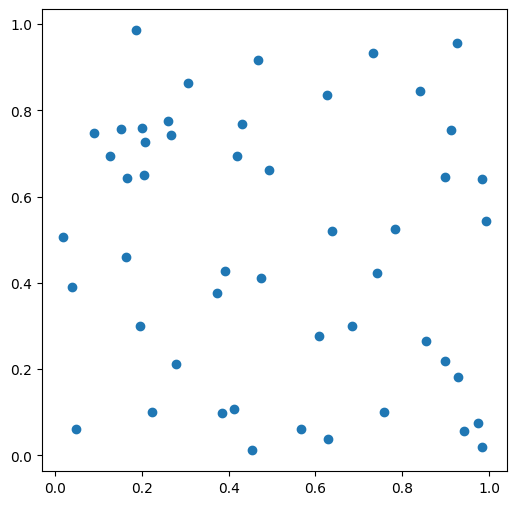

In [108]:
new_positions = jr.uniform(jr.PRNGKey(1), (50,2))

plt.figure(figsize=(6,6))
plt.scatter(new_positions[:,0], new_positions[:,1])
plt.show()